In [1]:
# Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Python's OS Package
import os

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# nltk imports
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Importing Data

In [2]:
df = pd.read_csv('nov2.1_df.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df.head()

,target,text,time,sia_positive,sia_negative,sia_neutral,sia_compound
0,0,RT @JulianCastro: My grandmother was a domesti...,10/29/2019 22:56,0.000,0.000,1.000,0.0000
1,1,RT @MayorOfLA: #GettyFire update | 8AM:\n\n- 5...,10/29/2019 22:56,0.000,0.000,1.000,0.0000
2,1,Getty Fire Ignited by Power Line in Sepulveda ...,10/29/2019 22:56,0.000,0.211,0.789,-0.3400
3,1,"RT @latimes: In an ominous new warning, the Na...",10/29/2019 22:56,0.000,0.202,0.798,-0.5859
4,1,Arson investigators from the Los Angeles Fire ...,10/29/2019 22:56,0.066,0.122,0.812,-0.2732


In [4]:
df['mention'] = np.where(df['text'].str.contains('@'), 1, 0)
df['https'] = np.where(df['text'].str.contains('http'), 1,0)
df['RT'] = np.where(df['text'].str.contains('RT'), 1,0)
df.head()

,target,text,time,sia_positive,sia_negative,sia_neutral,sia_compound,mention,https,RT
0,0,RT @JulianCastro: My grandmother was a domesti...,10/29/2019 22:56,0.000,0.000,1.000,0.0000,1,0,1
1,1,RT @MayorOfLA: #GettyFire update | 8AM:\n\n- 5...,10/29/2019 22:56,0.000,0.000,1.000,0.0000,1,0,1
2,1,Getty Fire Ignited by Power Line in Sepulveda ...,10/29/2019 22:56,0.000,0.211,0.789,-0.3400,0,1,0
3,1,"RT @latimes: In an ominous new warning, the Na...",10/29/2019 22:56,0.000,0.202,0.798,-0.5859,1,0,1
4,1,Arson investigators from the Los Angeles Fire ...,10/29/2019 22:56,0.066,0.122,0.812,-0.2732,0,1,0


In [5]:
df['target'].value_counts(normalize = True)

0    0.766858
1    0.233142
Name: target, dtype: float64

## X/Y Values

In [74]:
features = ['text', 'sia_positive']

In [83]:
X = df['text']
y = df['target']

In [52]:
X

,text,sia_positive,sia_negative,sia_compound
0,RT @JulianCastro: My grandmother was a domesti...,0.000,0.000,0.0000
1,RT @MayorOfLA: #GettyFire update | 8AM:\n\n- 5...,0.000,0.000,0.0000
2,Getty Fire Ignited by Power Line in Sepulveda ...,0.000,0.211,-0.3400
3,"RT @latimes: In an ominous new warning, the Na...",0.000,0.202,-0.5859
4,Arson investigators from the Los Angeles Fire ...,0.066,0.122,-0.2732
...,...,...,...,...
24405,lmao ima be heated if we don’t see any tonight...,0.302,0.000,0.5994
24406,It’s a bad dress. The wearer just made it wors...,0.000,0.304,-0.5423
24407,American nationalism is the Hope for the whole...,0.275,0.000,0.8625
24408,The ones we do have get shitted on lol All the...,0.106,0.102,0.0258


## Train Test Split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=248)

In [85]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(["b'RT",
                    "000",
                    "x80",
                    "x82"
                    "x8f",
                    "x99",
                    "x94",
                    "x98",
                    "x99m", 
                    "x99s",
                    "x9d",
                    "x9f",
                    "xa5",
                    "xa6",
                    "xa6'RT",
                    "xa6'b'RT",
                    "xa6'b'",
                    "xb8",
                    "xe2",
                    "xef",
                    "xf0",
                    "amp",
                    'angele',
                    'angeles',
                    "b'",
                    "Center",
                    'center',
                    'com',
                    "Getty",
                    'getty',
                    'gettyfire',
                    "Getty Center",
                    "GettyFire",
                    "instagram"
                    "htpps",
                    "http",
                    "nhttp", 
                    "nhttps",
                    'los',
                    "Los Angeles",
                    "Los Angele",
                    "Los", "Angele",
                    "outfit",
                    'rt',
                    "taco",
                    "truck",
                    "taco truck",
                    "www"
                    
                    
            ])

## Model

In [86]:
pipe_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bt', BaggingClassifier())
])

pipe_4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_ngram = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [89]:
pipe_1_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [300, 500, 1000],
    'tfidf__min_df': [5, 10, 20],
    'tfidf__max_df': [0.85, 0.8, 0.9],
    'lr__C': [0.001, 0.01, 1]
}

pipe_2_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [300, 500, 1000],
    'tfidf__min_df': [10, 25, 50],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'rf__max_depth' : [None, 1, 2],
#     'rf__min_samples_split' : [0.2, 0.4, 1],
    
}

pipe_3_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [1500, 1700, 2000],
    'tfidf__min_df': [35, 37, 42],
    'tfidf__max_df': [0.85, 0.9],
    'bt__n_estimators' : [1, 2, 3],
    'bt__max_samples' : [1, 2, 3],
    'bt__max_features' : [1, 2, 3],
}

pipe_4_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [1500, 1700, 2000],
    'tfidf__min_df': [35, 37, 42],
    'tfidf__max_df': [0.85, 0.9],
    'knn__n_neighbors': [3, 5, 7],
    'knn__leaf_size': [20, 30, 50],
#     'knn__p': [2, 3, 4],
}

param_ngram = {
    'cvec__stop_words': [custom_stop],
    'cvec__ngram_range': [(2,3), (3,3)]
}

In [90]:
gs_1 = GridSearchCV(pipe_1,
                   pipe_1_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
print('gs_1 completed')

gs_2 = GridSearchCV(pipe_2,
                   pipe_2_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
print('gs_2 completed')

gs_3 = GridSearchCV(pipe_3,
                   pipe_3_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
print('gs_3 completed')

gs_4 = GridSearchCV(pipe_4,
                   pipe_4_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
print('gs_4 completed')

gs_n_gram = GridSearchCV(pipe_ngram,
                        param_ngram,
                        cv = 5,
                        verbose = 1,
                        n_jobs=-1)
print('n_gram completed')

gs_1 completed
gs_2 completed
gs_3 completed
gs_4 completed
n_gram completed


In [91]:
gs_1.fit(X_train, y_train)
print(f'gs_1 best train score: {gs_1.best_score_}. gs_1 best test score: {gs_1.best_estimator_.score(X_test, y_test)}. The best train model from this grid search is {gs_1.best_estimator_}.')

gs_2.fit(X_train, y_train)
print(f'gs_2 best train score: {gs_2.best_score_}. gs_2 best test score: {gs_2.best_estimator_.score(X_test, y_test)}. The best model from this grid search is {gs_2.best_estimator_}')

gs_3.fit(X_train, y_train)
print(f'gs_3 best train score: {gs_3.best_score_}. gs_3 best test score: {gs_3.best_estimator_.score(X_test, y_test)}. The best model from this grid search is {gs_3.best_estimator_}')

gs_4.fit(X_train, y_train)
print(f'gs_4 best train score: {gs_4.best_score_}. gs_4 best test score: {gs_4.best_estimator_.score(X_test, y_test)}. The best model from this grid search is {gs_4.best_estimator_}')

gs_n_gram.fit(X_train, y_train)
print(f'gs_n_gram best train score: {gs_n_gram.best_score_}. gs_n_gram best test score {gs_n_gram.best_estimator_.score(X_test, y_test)}. The best model from this grid search is {gs_n_gram.best_estimator_}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.0min finished


gs_1 best train score: 0.9141858305566177. gs_1 best test score: 0.9118466328035393. The best train model from this grid search is Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.85, max_features=1000,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['per', 'de', 'full', 'each',
                                             'whence', 'my', 'was', 'empty',
                                             'ow...
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.2min finished
C:\Users\Brianna Lytle\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


gs_2 best train score: 0.9151144371005626. gs_2 best test score: 0.9210224479764051. The best model from this grid search is Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=1000,
                                 min_df=10, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['per', 'de', 'full', 'each',
                                             'whence', 'my', 'was', 'empty',
                                             'ow...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  9.7min finished


gs_3 best train score: 0.7680668596711641. gs_3 best test score: 0.766835982303785. The best model from this grid search is Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.85, max_features=1700,
                                 min_df=35, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['per', 'de', 'full', 'each',
                                             'whence', 'my', 'was', 'empty',
                                             'o...
                                             'detail', 'otherwise', ...],
                                 strip_accents=None, sublinear_tf=False,
  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 15.0min finished


gs_4 best train score: 0.8821762167476921. gs_4 best test score: 0.8761264951663117. The best model from this grid search is Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.85, max_features=1500,
                                 min_df=42, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['per', 'de', 'full', 'each',
                                             'whence', 'my', 'was', 'empty',
                                             'o...
                                             'during', 'sincere', 'more',
                                             'without', 'besides', 'eg', '

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.2s finished


gs_n_gram best train score: 0.8668268968154258. gs_n_gram best test score 0.8700639029985253. The best model from this grid search is Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(2, 3), preprocessor=None,
                                 stop_words=['per', 'de', 'full', 'each',
                                             'whence', 'my', 'was', 'empty',
                                             'own', 'beside', 'not', 'of', 'on',
                                             't...
                                             'detail', 'otherwise', ...],
                                 strip_accents=Non

In [93]:
gs_3.best_estimator_.score(X_train, y_train)

0.7668651335554706

## Predictions for Confusion Matrix

In [94]:
preds1 = gs_1.predict(X_test)
preds2 = gs_2.predict(X_test)
preds3 = gs_3.predict(X_test)
preds4 = gs_4.predict(X_test)
preds_ngram = gs_n_gram.predict(X_test)

## Confusion Matrix

In [193]:
print(f'gs_1 confusion matrix is \n{confusion_matrix(y_test, preds1)}')
print(f'gs_2 confusion matrix is \n{confusion_matrix(y_test, preds2)}')
print(f'gs_3 confusion matrix is \n{confusion_matrix(y_test, preds3)}')
print(f'gs_4 confusion matrix is \n{confusion_matrix(y_test, preds4)}')
print(f'gs_n_gram confusion matrix is \n{confusion_matrix(y_test, preds_ngram)}')

gs_1 confusion matrix is 
[[4535  145]
 [ 393 1030]]
gs_2 confusion matrix is 
[[4521  159]
 [ 323 1100]]
gs_3 confusion matrix is 
[[4680    0]
 [1423    0]]
gs_4 confusion matrix is 
[[4478  202]
 [ 554  869]]
gs_n_gram confusion matrix is 
[[4649   31]
 [ 762  661]]


In [124]:
# tn1, fp1, fn1, tp1 = confusion_matrix(y_test, preds1).ravel()
# tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()
# tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds3).ravel()
# tn4, fp4, fn4, tp4 = confusion_matrix(y_test, preds4).ravel()
# tn_n, fp_n, fn_n, tp_n = confusion_matrix(y_test, preds_ngram).ravel()

## ROC AUC Cuve

### Predictions for ROC Curve

In [177]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

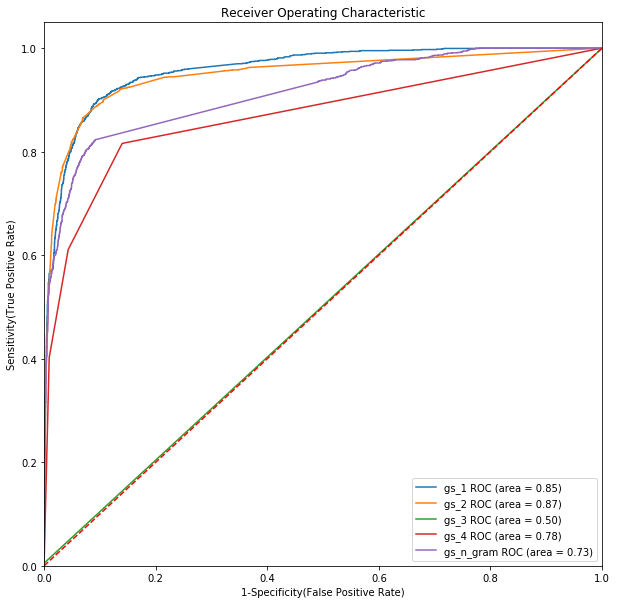

In [194]:
# pos_predict = []
models = [gs_1, gs_2, gs_3, gs_4 ,gs_n_gram]
model_names = ['gs_1', 'gs_2', 'gs_3', 'gs_4', 'gs_n_gram']
plt.figure(figsize = (10,10))
for z in range(len(models)):
    fpr, tpr, thresholds = roc_curve(y_test, models[z].predict_proba(X_test)[: , 1])
    auc = roc_auc_score(y_test, models[z].predict(X_test))
    plt.plot(fpr, tpr, label= '%s ROC (area = %0.2f)' % (model_names[z], auc))

# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

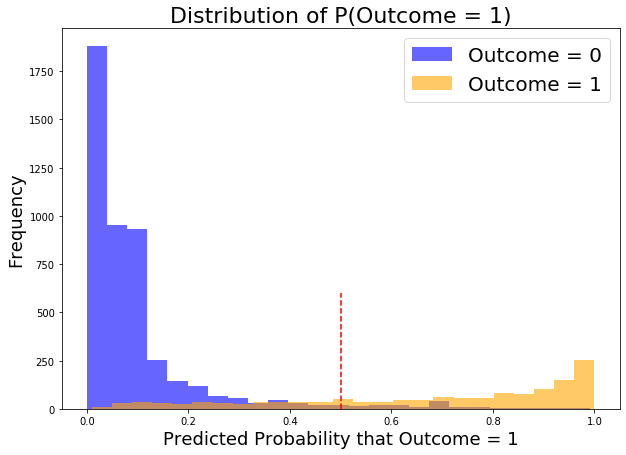

In [165]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 600,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);